#### Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.metrics import r2_score,mean_absolute_percentage_error,mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

pal=sns.color_palette()
pal_list = list(pal)

### **Preliminary analysis:**

#### **a. Import the dataset into the python environment**

In [2]:
items=pd.read_csv('items.csv') ## Loadning the items dataset
restaurants=pd.read_csv('resturants.csv') ## Loading the resturants dataset
sales=pd.read_csv('sales.csv') ## Loading the sales dataset

#### **b. Examine the dataset's shape and structure, and look out for any outlier**

In [3]:
## Check shape
print(f'Shape of items.csv: {items.shape}')
print(f'Shape of resturants.csv: {restaurants.shape}')
print(f'Shape of sales.csv: {sales.shape}')

Shape of items.csv: (100, 5)
Shape of resturants.csv: (6, 2)
Shape of sales.csv: (109600, 4)


In [4]:
# Check column information
print(items.info())
print(restaurants.info())
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        100 non-null    int64  
 1   store_id  100 non-null    int64  
 2   name      100 non-null    object 
 3   kcal      100 non-null    int64  
 4   cost      100 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6 non-null      int64 
 1   name    6 non-null      object
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     

In [5]:
# Check for missing values and outliers
print(items.isnull().sum())
print(restaurants.isnull().sum())
print(sales.isnull().sum())

id          0
store_id    0
name        0
kcal        0
cost        0
dtype: int64
id      0
name    0
dtype: int64
date          0
item_id       0
price         0
item_count    0
dtype: int64


In [6]:
## Finding the z-score on the basis of items count to find the outlires
outlires=sales.copy()
outlires['date']=pd.to_datetime(outlires['date'])
outlires=(pd.DataFrame(outlires.groupby('date')['item_count'].sum())).reset_index()
outlires['item_count_z-score']=stats.zscore(outlires['item_count'])

In [7]:
outlire=outlires[(outlires['item_count_z-score']>3)|(outlires['item_count_z-score']<-3)] ## applying condition if the data falling out of +3 z-score or less than -3 z-score or not
print(f'Number of outlires on item_count column of sales dataframe: {len(outlire)}')

Number of outlires on item_count column of sales dataframe: 0


#### **c.  Merge the datasets into a single dataset that includes the date, item id, price, item count, item names, kcal values, store id, and store name**

In [8]:
# Merge sales with items
sales_items_df = pd.merge(sales, items, left_on='item_id', right_on='id',how="left")

In [9]:
# Merge with restaurants
final_df = pd.merge(sales_items_df, restaurants, left_on='store_id', right_on='id')

In [10]:
final_df.head()

,date,item_id,price,item_count,id_x,store_id,name_x,kcal,cost,id_y,name_y
0,2019-01-01,3,29.22,2.0,3,1,Sweet Fruity Cake,931,29.22,1,Bob's Diner
1,2019-01-01,4,26.42,22.0,4,1,Amazing Steak Dinner with Rolls,763,26.42,1,Bob's Diner
2,2019-01-01,12,4.87,7.0,12,1,Fantastic Sweet Cola,478,4.87,1,Bob's Diner
3,2019-01-01,13,4.18,12.0,13,1,Sweet Frozen Soft Drink,490,4.18,1,Bob's Diner
4,2019-01-01,16,3.21,136.0,16,1,Frozen Milky Smoothy,284,3.21,1,Bob's Diner


In [11]:
# Select required columns
df=final_df[['date', 'item_id', 'price', 'item_count', 'name_x', 'kcal', 'store_id', 'name_y']]

In [12]:
# Rename the columns for better understanding
df=df.rename(columns={'name_x':'item_names','name_y':'store_name','cost':'price'})

In [13]:
df.head()

,date,item_id,price,item_count,item_names,kcal,store_id,store_name
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner
1,2019-01-01,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner
2,2019-01-01,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner
3,2019-01-01,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner
4,2019-01-01,16,3.21,136.0,Frozen Milky Smoothy,284,1,Bob's Diner


### **Exploratory data analysis:**

#### **a.  Examine the overall date wise sales to understand the pattern**

In [14]:
## Converting the date column to pandas datetime feature
df['date']=pd.to_datetime(df['date'])
# Aggregate sales by date
date_sales = df.groupby('date')['item_count'].sum().reset_index()

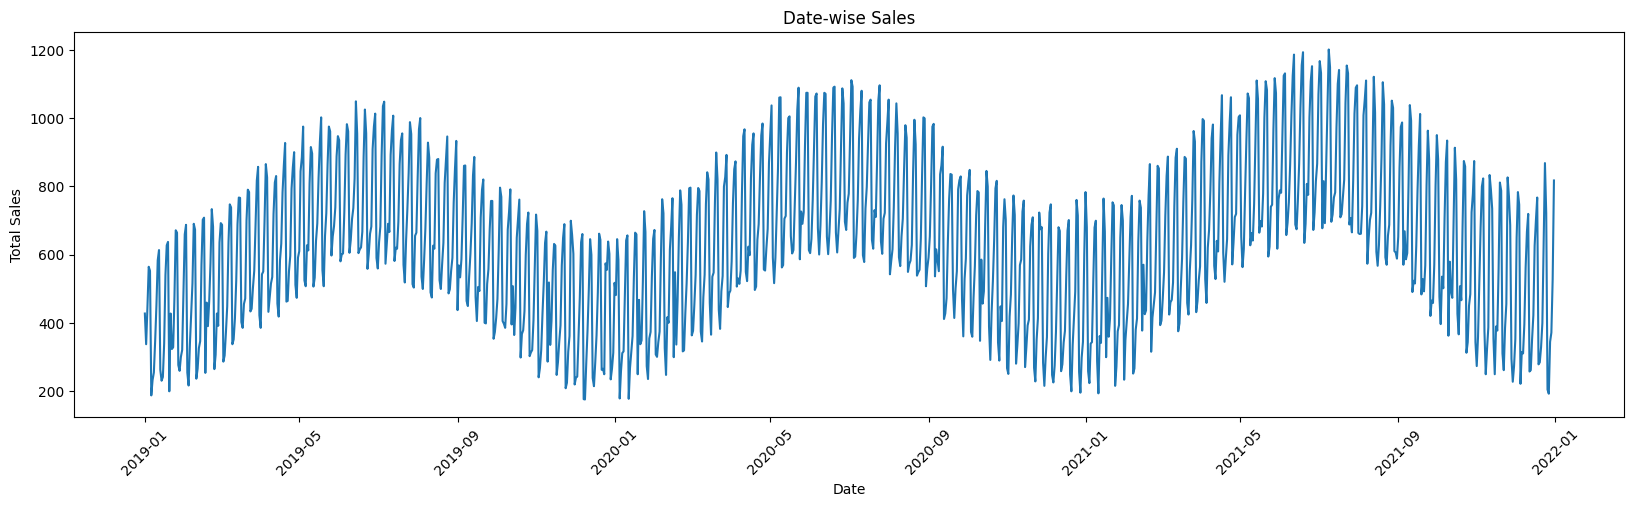

In [15]:
# Plot sales over time
plt.figure(figsize = (20,5))
plt.plot(date_sales['date'], date_sales['item_count'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.title('Date-wise Sales')
plt.show()

#### **b.  Find out how sales fluctuate across different days of the week**

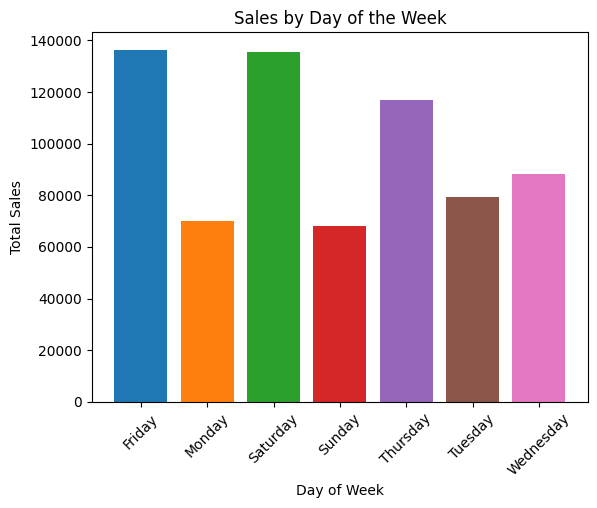

In [16]:
df['day_of_week'] = df['date'].dt.day_name()
day_sales = (df.groupby('day_of_week')['item_count'].sum()).reset_index()

# Plot sales by day of the week
plt.bar(day_sales['day_of_week'], day_sales['item_count'],color=pal)
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.title('Sales by Day of the Week')
plt.show()

From the plot we can say that in Thursday, Friday and Saturday the sales are going very high. But in the starting of the weekdays and in Sundays the sales are not so impressive.

#### **c.  Look for any noticeable trends in the sales data for different months of the year**

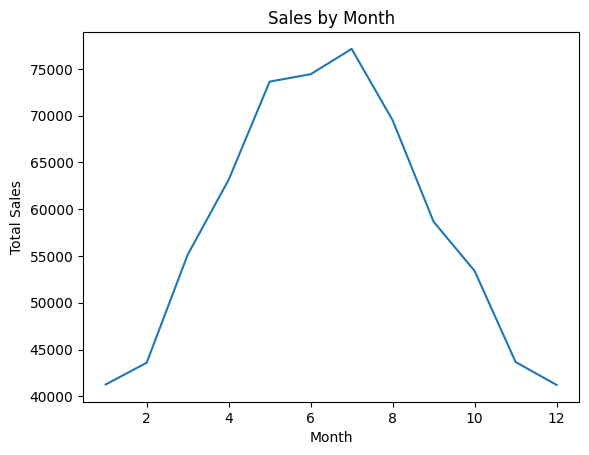

In [17]:
df['month'] = df['date'].dt.month
month_sales = df.groupby('month')['item_count'].sum().reset_index()
# Plot monthly sales
plt.plot(month_sales['month'], month_sales['item_count'])
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Sales by Month')
plt.show()

After analyzing the trend of the sales on the basis of month we can say in the middle of the months the sales are going very high and in the starting and the end of the year the sales are not so good.

#### **d.  Examine the sales distribution across different quarters averaged over the years. Identify any noticeable patterns.**

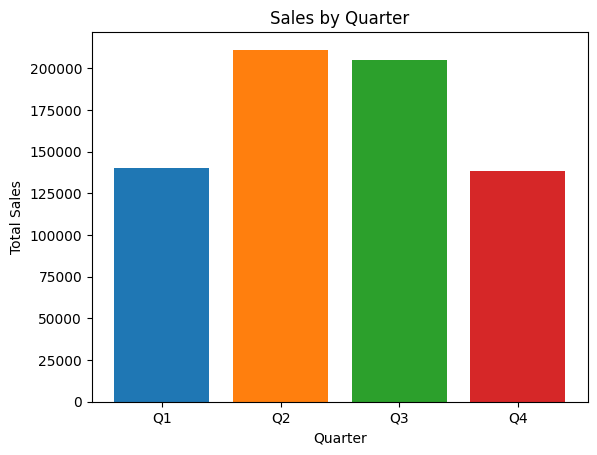

In [18]:
df['quarter'] = df['date'].dt.quarter
quarter_sales = df.groupby('quarter')['item_count'].sum().reset_index()
# Plot quarterly sales
plt.bar(quarter_sales['quarter'], quarter_sales['item_count'],color=pal)
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.xticks(range(1,5),["Q"+str(i) for i in range(1,5)])
plt.title('Sales by Quarter')
plt.show()

By visualizing the plot we can interpate that the sales in the Q2 and Q3 are the most and greater than the sales made in Q1 and Q4. Which is again the middle of the year.

#### **e.  Compare the performances of the different restaurants. Find out which restaurant had the most sales and look at the sales for each restaurant across different years, months, and days.**

In [19]:
restaurant_sales = df.groupby('store_name')['item_count'].sum().reset_index()
top_restaurant = restaurant_sales[restaurant_sales['item_count'] == restaurant_sales['item_count'].max()]
print("The performance of each restaurants:\n")
for restaurant,performance in zip(restaurant_sales['store_name'],restaurant_sales['item_count']):
  print(f"{restaurant}\t:{performance:.2f}")

The performance of each restaurants:

Beachfront Bar	:1305.00
Bob's Diner	:687527.00
Corner Cafe	:1310.00
Fou Cher	:1106.00
Surfs Up	:1803.00
Sweet Shack	:1736.00


In [20]:
print(f"The restaurent having the most sales: {top_restaurant.iloc[0,0]}")

The restaurent having the most sales: Bob's Diner


In [21]:
df['year']=df['date'].dt.year
year_wise_pivot=df.pivot_table(values='item_count',index='year',columns='store_id',aggfunc='sum')

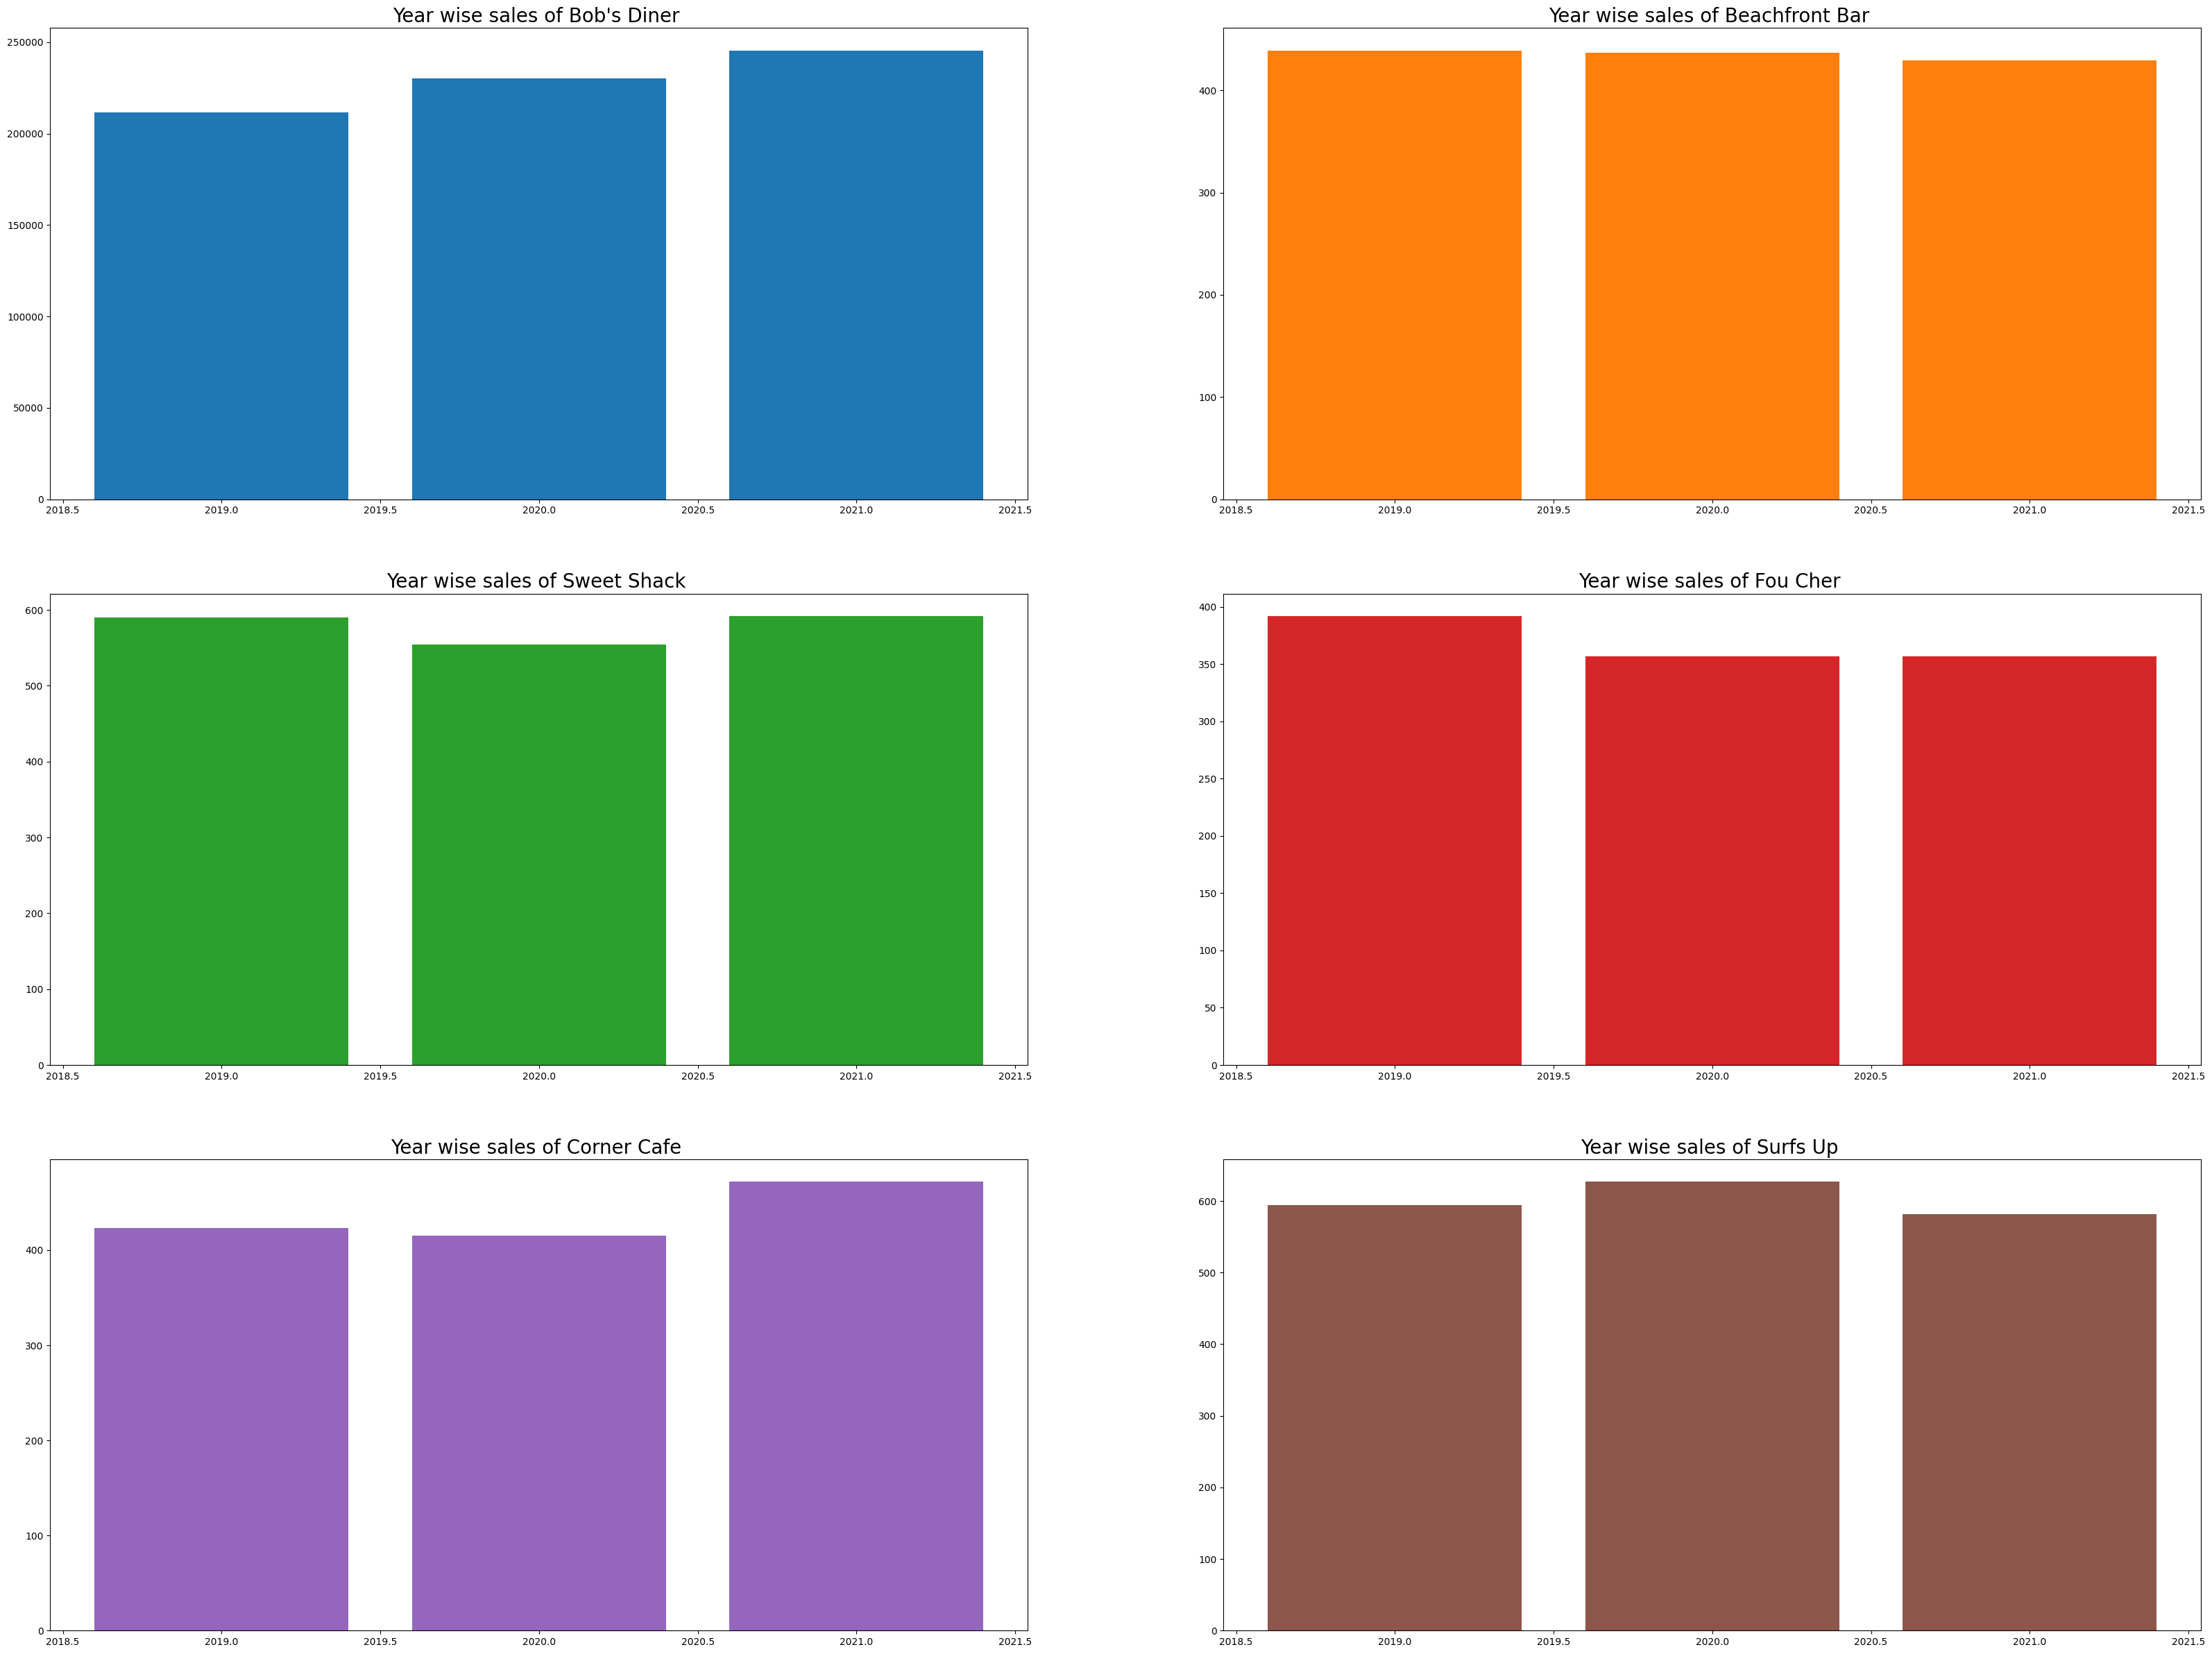

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(40, 30))
r,c = 0,0
for i in range(1,7):
  axs[r,c].bar(x = year_wise_pivot.index,height = year_wise_pivot.loc[:, i], color = pal_list[i-1])
  axs[r,c].set_title('Year wise sales of {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c += 1
  if c == 2:
    c = 0
    r +=1

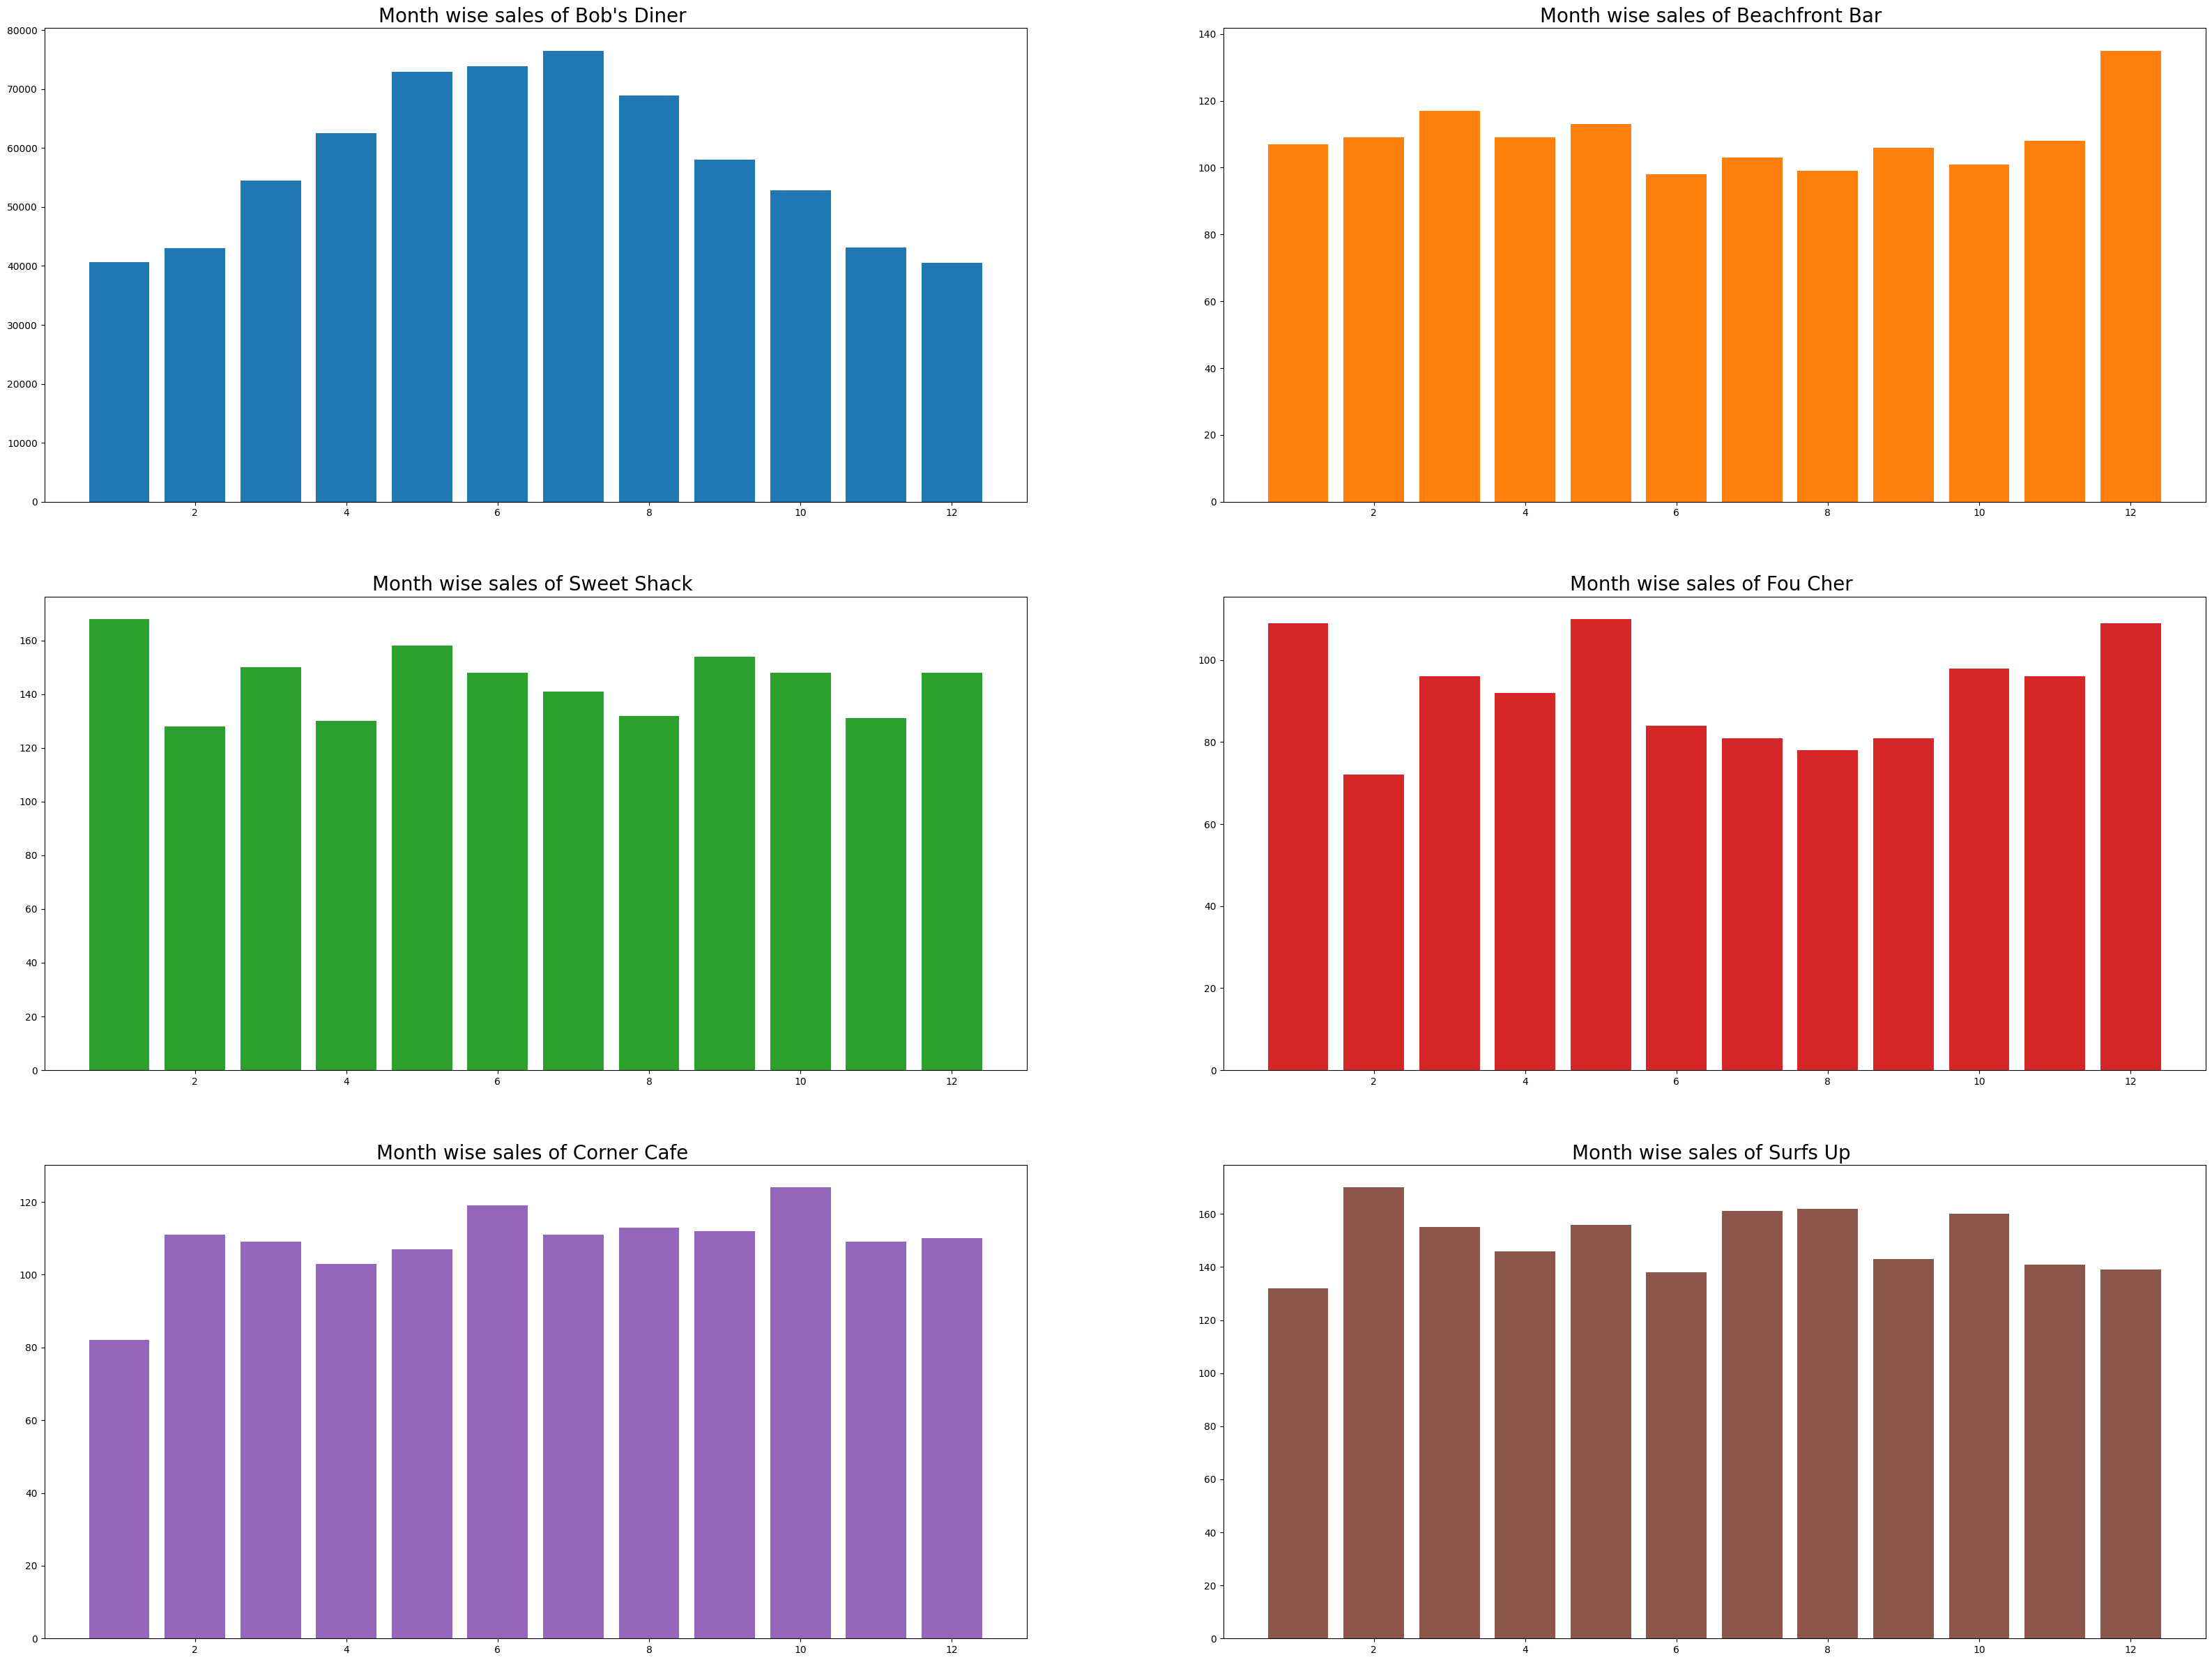

In [23]:
month_wise_pivot=df.pivot_table(values='item_count',index='month',columns='store_id',aggfunc='sum')
fig1, axs1 = plt.subplots(3, 2, figsize=(40, 30))
r1,c1 = 0,0
for i in range(1,7):
  axs1[r1,c1].bar(x = month_wise_pivot.index,height = month_wise_pivot.loc[:, i], color = pal_list[i-1])
  axs1[r1,c1].set_title('Month wise sales of {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c1 += 1
  if c1 == 2:
    c1 = 0
    r1 +=1

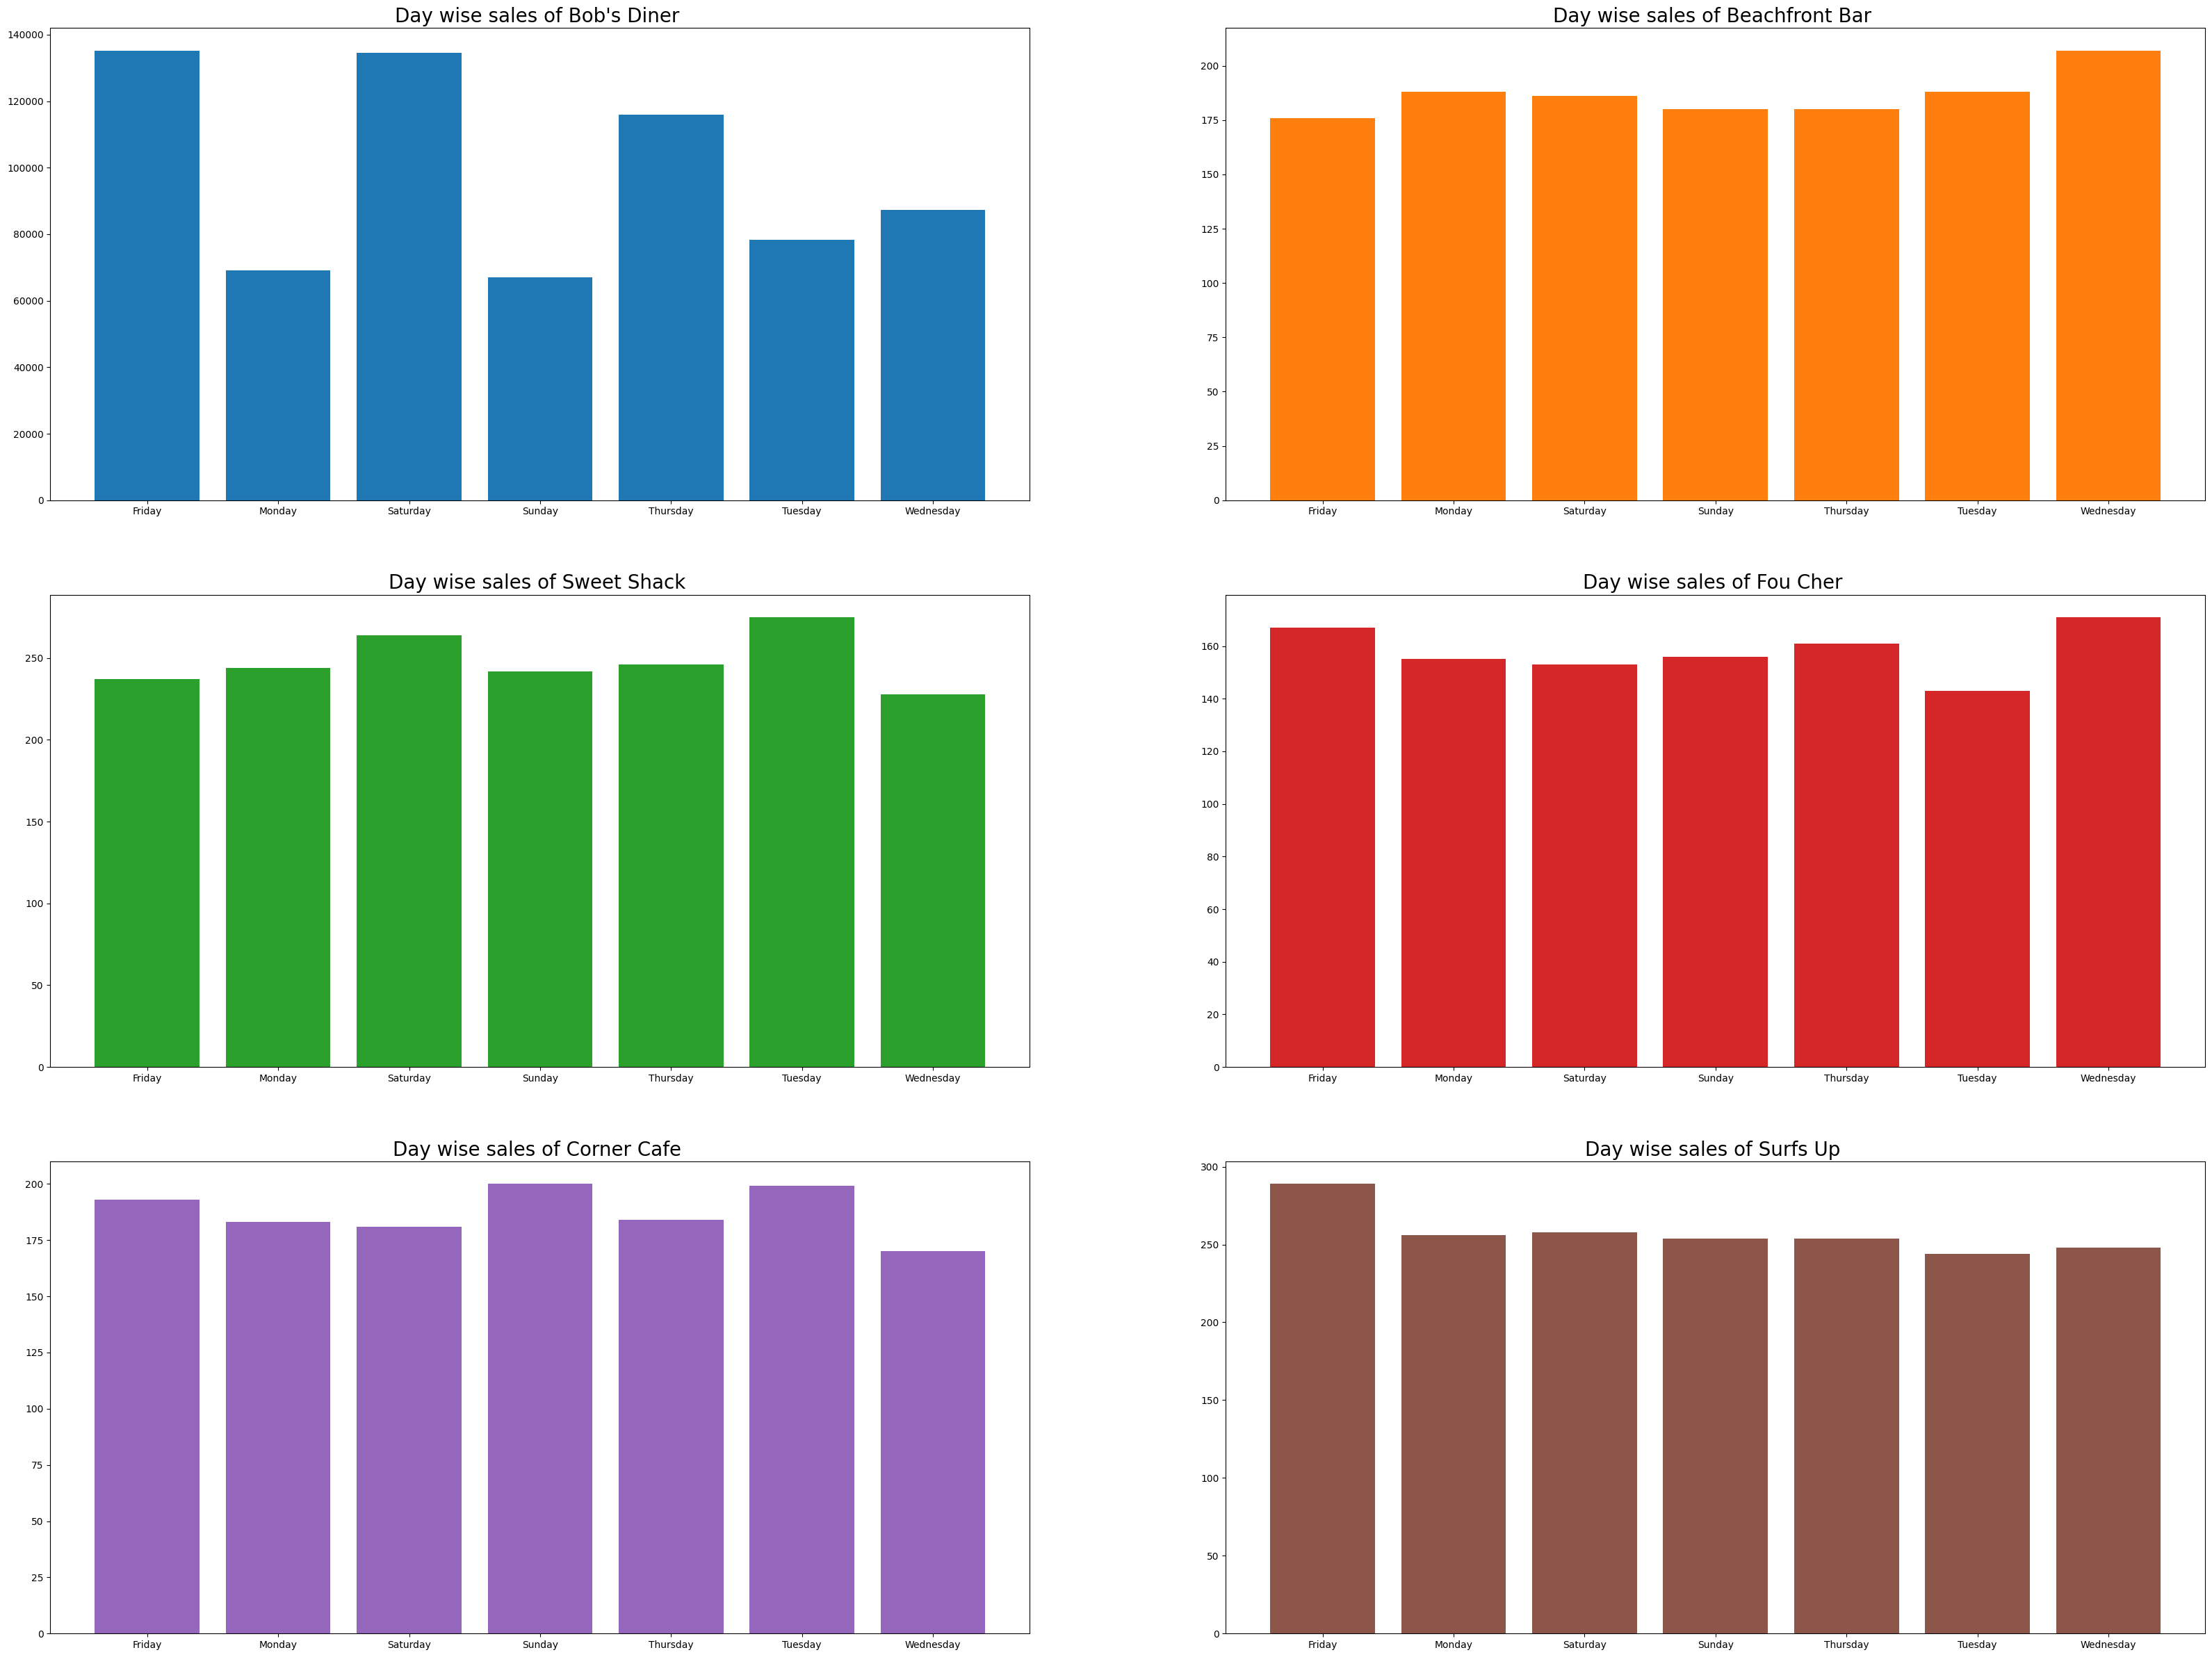

In [24]:
day_wise_pivot=df.pivot_table(values='item_count',index='day_of_week',columns='store_id',aggfunc='sum')
fig2, axs2 = plt.subplots(3, 2, figsize=(40, 30))
r2,c2 = 0,0
for i in range(1,7):
  axs2[r2,c2].bar(x = day_wise_pivot.index,height = day_wise_pivot.loc[:, i], color = pal_list[i-1])
  axs2[r2,c2].set_title('Day wise sales of {} '.format(restaurants.loc[restaurants.id == i, 'name'].values[0]), size = 20)
  c2 += 1
  if c2 == 2:
    c2 = 0
    r2 +=1

#### **f.  Identify the most popular items overall and the stores where they are being sold. Also, find out the most popular item at each store**

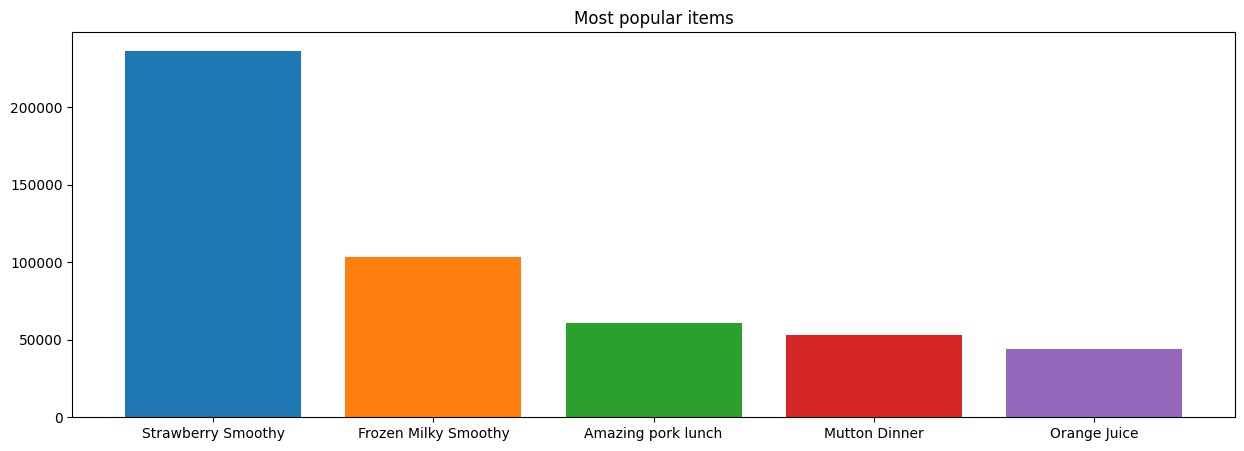

In [25]:
most_popular_item=(df.groupby('item_names')['item_count'].sum()).sort_values(ascending=False)[0:5]
plt.figure(figsize=(15,5))
plt.bar(x=most_popular_item.index,height=most_popular_item.values,color=pal)
plt.title('Most popular items')
plt.show()

In [26]:
print("Most popular items and the restaurents they are sold:\n")
for i in most_popular_item.index:
  i_df=df[df['item_names']==i]['store_name'].unique()
  for j in i_df:
    print(f"{i}\t:{j}")

Most popular items and the restaurents they are sold:

Strawberry Smoothy	:Bob's Diner
Frozen Milky Smoothy	:Bob's Diner
Frozen Milky Smoothy	:Corner Cafe
Amazing pork lunch	:Bob's Diner
Mutton Dinner	:Bob's Diner
Orange Juice	:Bob's Diner


In [27]:
store_wise_popular_items={}
for store in df['store_name'].unique():
  key_value=((df[df['store_name']==store].groupby('item_names')['item_count'].sum()).sort_values(ascending=False))[0:1]
  store_wise_popular_items[store]=key_value.index[0]

In [28]:
print('Most popular items in each store:\n')
for key,values in store_wise_popular_items.items():
  print(f"{key}\t: {values}")

Most popular items in each store:

Bob's Diner	: Strawberry Smoothy
Surfs Up	: Awesome Soft Drink
Beachfront Bar	: Fantastic Milky Smoothy
Fou Cher	: Blue Ribbon Fruity Vegi Lunch
Corner Cafe	: Frozen Milky Smoothy
Sweet Shack	: Awesome Smoothy


#### **g.  Determine if the store with the highest sales volume is also making the most money per day**

In [29]:
sales_df=df.copy()
sales_df['sales']=sales_df['price']*sales_df['item_count']
heighest_sales_volume=(sales_df.groupby('store_name')['item_count'].sum()).sort_values(ascending=False).index[0]
mean_sales={}
for restaurent in sales_df['store_name'].unique():
  restaurents_total_sales=sales_df[sales_df['store_name']==restaurent].groupby('date')['sales'].sum()
  mean_sales_per_day=sum(restaurents_total_sales)/len(restaurents_total_sales)
  mean_sales[restaurent]=mean_sales_per_day

In [30]:
if heighest_sales_volume == max(mean_sales,key=mean_sales.get):
  print(f"The store {heighest_sales_volume} with the heighest sales volume is also making the most money per day.")
else:
  print(f"The store with the heighest sales volume is not making the most money per day.")

The store Bob's Diner with the heighest sales volume is also making the most money per day.


#### **h.  Identify the most expensive item at each restaurant and find out its calorie count**

In [31]:
store_wise_expensive_items={}
for store in df['store_name'].unique():
  dataframe=df[df['store_name']==store]
  df_items=list(dataframe['item_names'].unique())
  item_df=items[items['name'].isin(df_items)].sort_values(by='cost',ascending=False)[0:1]
  store_wise_expensive_items[store]=[(item_df['name'].values[0]),(item_df['kcal'].values[0])]

In [32]:
print("The most expensive items in each store:\n")
for key,(v1,v2) in store_wise_expensive_items.items():
    print(f"{key}\t: {v1} ({v2.round(2)} kcal)")

The most expensive items in each store:

Bob's Diner	: Sweet Fruity Cake (931 kcal)
Surfs Up	: Steak Meal (607 kcal)
Beachfront Bar	: Sweet Vegi Soft Drink (538 kcal)
Fou Cher	: Blue Ribbon Fruity Vegi Lunch (881 kcal)
Corner Cafe	: Pike Lunch (653 kcal)
Sweet Shack	: Blue Ribbon Frozen Milky Cake (636 kcal)


### **Forecasting using machine learning algorithms:**

#### **a. Build and compare linear regression, random forest, and XGBoost models for predictions**

* Generate necessary features for the development of these models, like day of the week, quarter of the year, month, year, day of the month and so on

In [33]:
## Cteating a column for day of the month
df['day_of_month']=df['date'].dt.day

In [34]:
df.head()

,date,item_id,price,item_count,item_names,kcal,store_id,store_name,day_of_week,month,quarter,year,day_of_month
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner,Tuesday,1,1,2019,1
1,2019-01-01,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner,Tuesday,1,1,2019,1
2,2019-01-01,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner,Tuesday,1,1,2019,1
3,2019-01-01,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner,Tuesday,1,1,2019,1
4,2019-01-01,16,3.21,136.0,Frozen Milky Smoothy,284,1,Bob's Diner,Tuesday,1,1,2019,1


In [35]:
# Creating a time series data
time_series = df.groupby(['date']).agg({'item_count':'sum', 'day_of_week': lambda x :x.unique()[0],
                            'quarter' : lambda x :x.unique()[0], 'year': lambda x :x.unique()[0],
                            'month' : lambda x :x.unique()[0],
                            'day_of_month':lambda x :x.unique()[0]})

In [36]:
# Adding more feature
time_series['week_num'] = time_series.index.isocalendar().week.astype(int)

In [37]:
time_series.head()

,item_count,day_of_week,quarter,year,month,day_of_month,week_num
date,,,,,,,
2019-01-01,427.0,Tuesday,1,2019,1,1,1
2019-01-02,337.0,Wednesday,1,2019,1,2,1
2019-01-03,445.0,Thursday,1,2019,1,3,1
2019-01-04,564.0,Friday,1,2019,1,4,1
2019-01-05,552.0,Saturday,1,2019,1,5,1


In [38]:
label_encoder=LabelEncoder()
time_series['day_of_week']=label_encoder.fit_transform(time_series['day_of_week'])

* Use the data from the last six months as the testing data

In [39]:
# Splitting the data into training and testing
train = time_series[time_series.index < '2021-07-01']
test = time_series[time_series.index >= '2021-07-01']

In [40]:
## Preparing the data for model training
x_train=(train.drop('item_count',axis=1))
y_train=train['item_count']
x_test=(test.drop('item_count',axis=1))
y_test=test['item_count']

* Compute the root mean square error (RMSE) values for each model to compare their performances.

In [41]:
linear_regression=LinearRegression()
random_forest_regressor=RandomForestRegressor(n_estimators=100,criterion='squared_error',random_state=42)
xgb_regressor=XGBRegressor(objective ='reg:linear',n_estimators=100,random_state=42)

In [42]:
linear_regression.fit(x_train,y_train)
random_forest_regressor.fit(x_train,y_train)
xgb_regressor.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:15:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [43]:
print(f"RMSE on linear regression on test data:\n\t{np.sqrt(mean_squared_error(y_test,linear_regression.predict(x_test)))}")
print(f"RMSE on RandomForest regression on test data:\n\t{np.sqrt(mean_squared_error(y_test,random_forest_regressor.predict(x_test)))}")
print(f"RMSE on XGBoost regression on test data:\n\t{np.sqrt(mean_squared_error(y_test,xgb_regressor.predict(x_test)))}")

RMSE on linear regression on test data:
	246.9684746492058
RMSE on RandomForest regression on test data:
	61.22778435179926
RMSE on XGBoost regression on test data:
	56.38479493809363


In [44]:
print(f"R2 score on linear regression on test data:\n\t{(r2_score(y_test,linear_regression.predict(x_test)))}")
print(f"R2 score on RandomForest regression on test data:\n\t{(r2_score(y_test,random_forest_regressor.predict(x_test)))}")
print(f"R2 score on XGBoost regression on test data:\n\t{(r2_score(y_test,xgb_regressor.predict(x_test)))}")

R2 score on linear regression on test data:
	0.05552067806328265
R2 score on RandomForest regression on test data:
	0.9419494280420073
R2 score on XGBoost regression on test data:
	0.9507695930357847


We can use xgb_regressor to forecasting of the next year as both the RMSE and R2 score is justifying the most accuracy of the model.

* Use the best-performing models to make a forecast for the next year

In [45]:
print(time_series.index.max()) # Print the last date mentioned in the dataframe

2021-12-31 00:00:00


In [46]:
# Create time series data
future_predictors = pd.DataFrame(pd.date_range(start="2022-01-01", end="2022-12-31"), columns=['date'])
future_predictors.index = pd.to_datetime(future_predictors.date)

In [47]:
# Check the columns exist in the training data
x_train.columns

Index(['day_of_week', 'quarter', 'year', 'month', 'day_of_month', 'week_num'], dtype='object')

In [48]:
# Create the dataframe to predict future sales
future_predictors['day_of_week'] = future_predictors.date.dt.day_name()
future_predictors['quarter'] = future_predictors.date.dt.quarter
future_predictors['year'] = future_predictors.date.dt.year
future_predictors['month'] = future_predictors.date.dt.month
future_predictors['day_of_month'] = future_predictors.date.dt.day
future_predictors['week_num'] = future_predictors.index.isocalendar().week.astype(int)

In [49]:
future_predictors['day_of_week']=label_encoder.transform(future_predictors['day_of_week'])
future_predictors=future_predictors.drop('date',axis=1)

In [50]:
future_predictors.head()

,day_of_week,quarter,year,month,day_of_month,week_num
date,,,,,,
2022-01-01,2,1,2022,1,1,52
2022-01-02,3,1,2022,1,2,52
2022-01-03,1,1,2022,1,3,1
2022-01-04,5,1,2022,1,4,1
2022-01-05,6,1,2022,1,5,1


In [51]:
# Make a seperate dataframe for the forecasting
future_prediction=future_predictors.copy()
future_prediction['item_count']=xgb_regressor.predict(future_predictors)

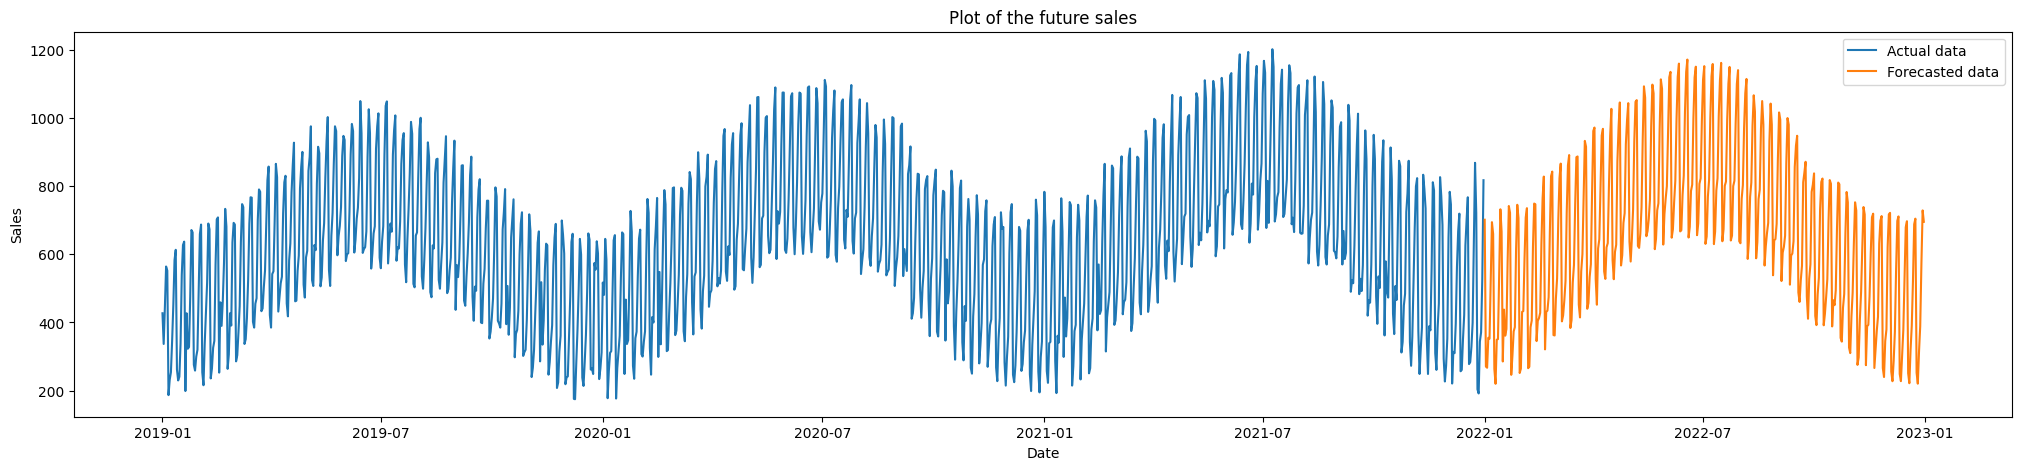

In [52]:
plt.figure(figsize=(25,5))
plt.plot(time_series.item_count,label="Actual data")
plt.plot(future_prediction.item_count,label="Forecasted data")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Plot of the future sales')
plt.legend()
plt.show()

### **Forecasting using deep learning algorithms:**

#### **a.  Use sales amount for predictions instead of item count**

In [53]:
# Making dataframes for training and testing
df['sales']=df['item_count']*df['price']

In [54]:
df.head()

,date,item_id,price,item_count,item_names,kcal,store_id,store_name,day_of_week,month,quarter,year,day_of_month,sales
0,2019-01-01,3,29.22,2.0,Sweet Fruity Cake,931,1,Bob's Diner,Tuesday,1,1,2019,1,58.44
1,2019-01-01,4,26.42,22.0,Amazing Steak Dinner with Rolls,763,1,Bob's Diner,Tuesday,1,1,2019,1,581.24
2,2019-01-01,12,4.87,7.0,Fantastic Sweet Cola,478,1,Bob's Diner,Tuesday,1,1,2019,1,34.09
3,2019-01-01,13,4.18,12.0,Sweet Frozen Soft Drink,490,1,Bob's Diner,Tuesday,1,1,2019,1,50.16
4,2019-01-01,16,3.21,136.0,Frozen Milky Smoothy,284,1,Bob's Diner,Tuesday,1,1,2019,1,436.56


In [55]:
time_series_dl=df.groupby(['date']).agg({'sales':'sum'})

In [56]:
time_series_dl.head()

,sales
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53


#### **b.  Build a long short-term memory (LSTM) model for predictions**
* Define the train and test series

In [57]:
# Spliting the data into input and output labels
train_dl = time_series_dl[time_series_dl.index < '2021-07-01']
test_dl = time_series_dl[time_series_dl.index >= '2021-07-01']

In [58]:
# Scaling the data
scale=MinMaxScaler()
scaled_train=scale.fit_transform(train_dl)
scaled_test=scale.transform(test_dl)

In [59]:
np.shape(scaled_train)

(912, 1)

* Generate synthetic data for the last 12 months

In [60]:
# Generate synthetic data
length=12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

* Build and train an LSTM model

In [61]:
# Make the model
model=Sequential([
    LSTM(64,activation='relu',input_shape=(length,n_features)),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error')

In [63]:
# # Making a early stopping callback
early_stopping=EarlyStopping(patience=5,monitor='val_loss')

In [64]:
# Fit the model on the trainig dataset and validate in test data
history=model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stopping])

Epoch 1/20
 18/900 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0472

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0404 - val_loss: 0.0231
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.0118 - val_loss: 0.0084
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0056 - val_loss: 0.0064
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0046 - val_loss: 0.0214
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0047 - val_loss: 0.0080
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0041 - val_loss: 0.0117


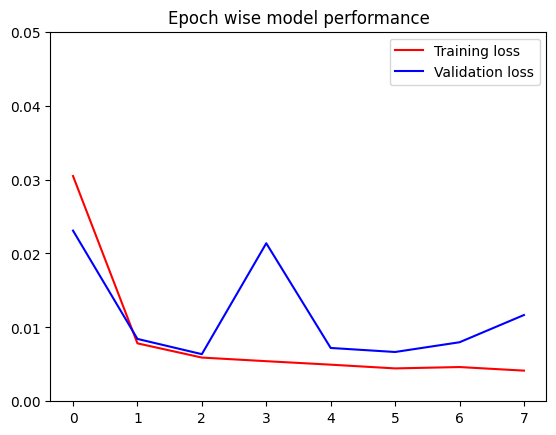

In [65]:
plt.plot(history.history['loss'],label='Training loss',c='red')
plt.plot(history.history['val_loss'],label='Validation loss',c='blue')
plt.title('Epoch wise model performance')
plt.ylim(0,0.05)
plt.legend()
plt.show()

* Use the model to make predictions for the test data

In [66]:
y_pred=model.predict(scaled_test)
r2_score(scaled_test,y_pred)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


0.8866435308786343

In [67]:
model_pred=test_dl.copy()
model_pred['prediction']=scale.inverse_transform(model.predict(scaled_test))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [68]:
model_pred.head()

,sales,prediction
date,,
2021-07-01,10290.33,9884.441406
2021-07-02,11028.59,10504.643555
2021-07-03,10793.51,10306.453125
2021-07-04,6524.13,6924.140137
2021-07-05,7983.57,8035.509766


In [69]:
model_pred=model_pred.drop('sales',axis=1)

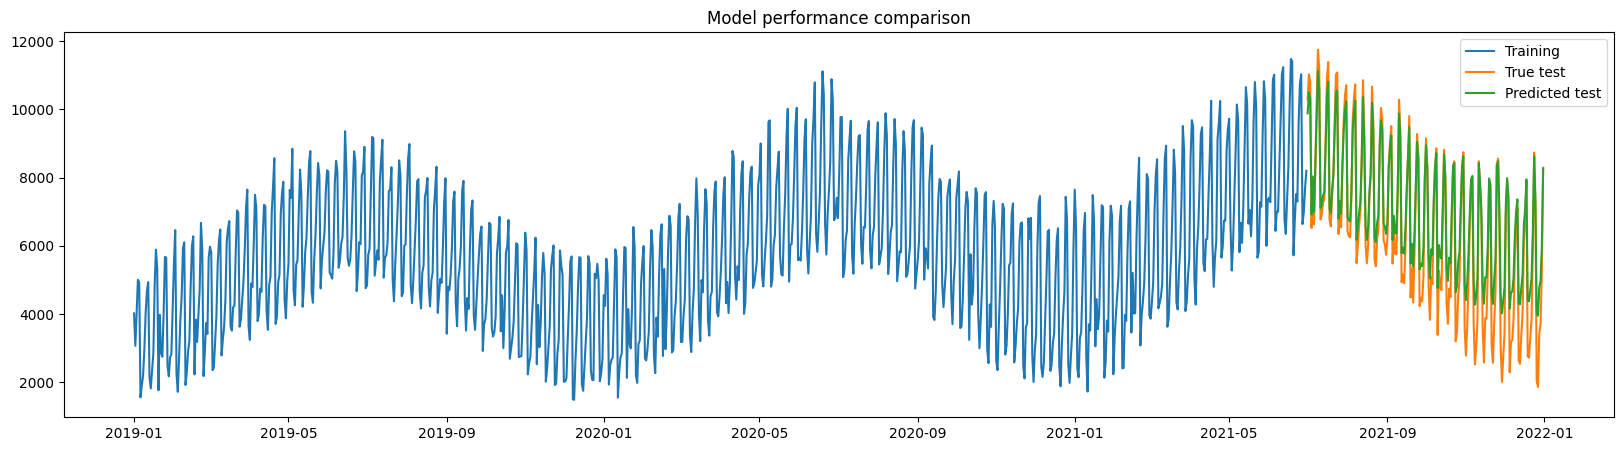

In [70]:
plt.figure(figsize=(20,5))
plt.plot(train_dl,label='Training')
plt.plot(test_dl,label='True test')
plt.plot(model_pred,label='Predicted test')
plt.title('Model performance comparison')
plt.legend()
plt.show()

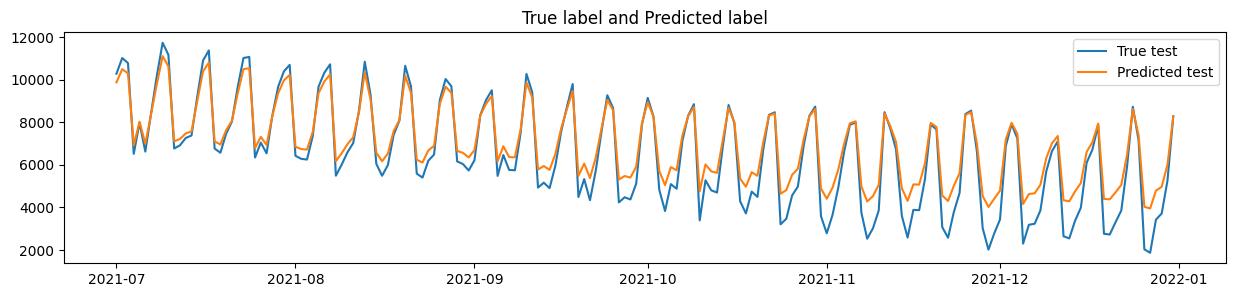

In [71]:
plt.figure(figsize=(15,3))
plt.plot(test_dl,label='True test')
plt.plot(model_pred,label='Predicted test')
plt.title('True label and Predicted label')
plt.legend()
plt.show()

#### **c.  Calculate the mean absolute percentage error (MAPE) and comment on the model's performance**

In [72]:
print(f'Mean absolute percentage error: {(mean_absolute_percentage_error(scaled_test,y_pred)):.4f}')

Mean absolute percentage error: 0.3230


Here the MAPE is around 0.32 which can be told as the model's output is off by around 32% which is a moderate score with the R2 score of 0.88.

#### **d.  Develop another model using the entire series for training, and use it to forecast for the next three months**

In [73]:
time_series_dl.head()

,sales
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53


In [74]:
scale_data=StandardScaler()
scaled_time_series=scale_data.fit_transform(time_series_dl)

In [75]:
#Data preperation
len_data=15
num_features=1
generator_lstm = TimeseriesGenerator(scaled_time_series, scaled_time_series, length=len_data, batch_size=1)

In [76]:
# Make the model
model_lstm=Sequential([
    LSTM(150,activation='relu',input_shape=(length,n_features)),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
# Compile the model
model_lstm.compile(optimizer='adam',loss='mean_squared_error')

In [78]:
# Fit the model on the trainig dataset and validate in test data
history_lstm=model_lstm.fit(generator_lstm,epochs=10,
                   callbacks=[early_stopping])

Epoch 1/10
   7/1081 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - loss: 1.6567

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.8218
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1081/1081 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.4302
Epoch 3/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.2066
Epoch 4/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.1176
Epoch 5/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.1107
Epoch 6/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.1058
Epoch 7/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0945
Epoch 8/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0818
Epoch 9/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0793
Epoch 10/10
1081/1081 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0726


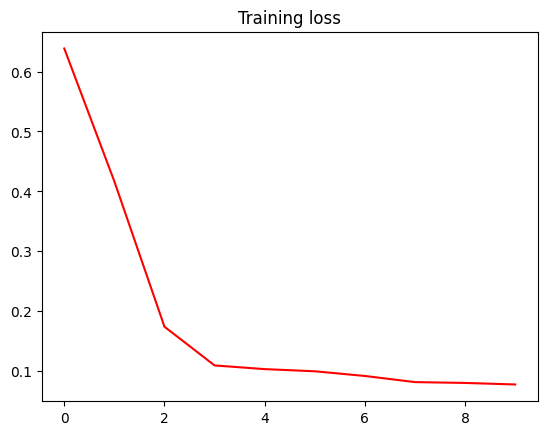

In [79]:
plt.plot(history_lstm.history['loss'],color='red')
plt.title('Training loss')
plt.show()

In [80]:
forecast_dates = pd.date_range(start='2022-01-01', periods=3*30, freq='D')

In [81]:
forecast = []
periods = 3*30

first_batch = scaled_time_series[-len_data:]
current_batch = first_batch.reshape((1,len_data, num_features))

for i in range(periods):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model_lstm.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━

In [82]:
forecast = scale_data.inverse_transform(forecast)
forecast_data = pd.DataFrame(data=forecast,index=forecast_dates,
                           columns=['Forecast']).squeeze()

In [83]:
forecast_data.head()

,Forecast
2022-01-01,7881.286189
2022-01-02,2749.796750
2022-01-03,2795.329383
2022-01-04,3497.826734
2022-01-05,4153.504410


In [84]:
time_series_dl.head()

,sales
date,
2019-01-01,4023.00
2019-01-02,3074.69
2019-01-03,4062.71
2019-01-04,5006.81
2019-01-05,4927.53


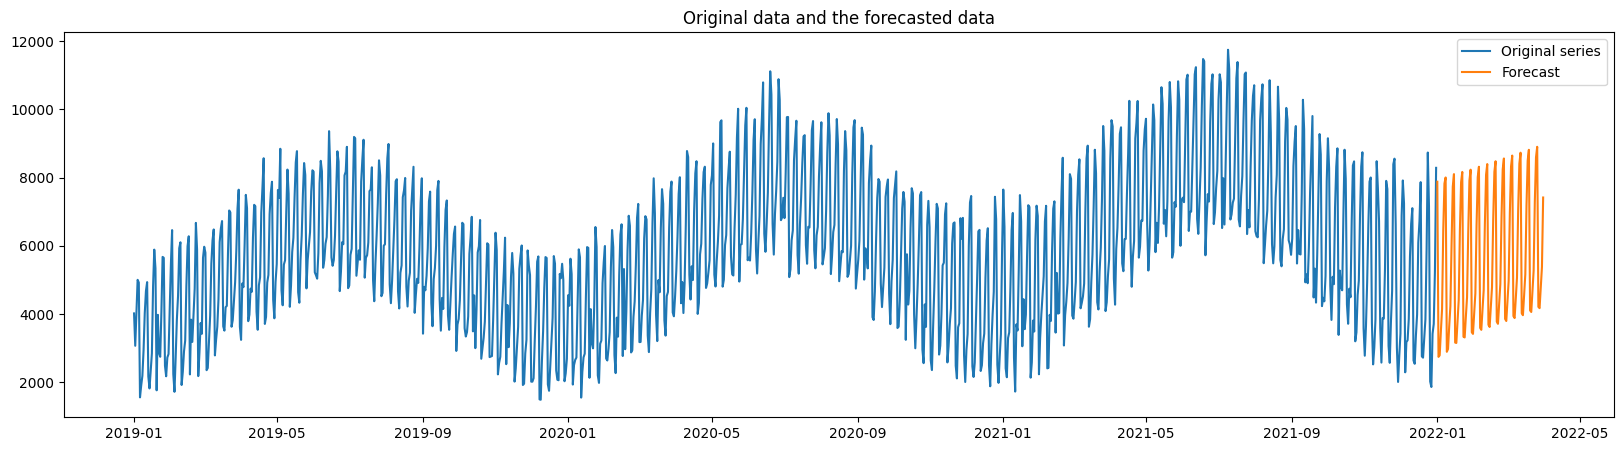

In [85]:
plt.figure(figsize = (20,5))
plt.plot(time_series_dl, label = 'Original series')
plt.plot(forecast_data, label = 'Forecast')
plt.title('Original data and the forecasted data')
plt.legend()
plt.show()